# Installing Dependencies

In [ ]:
# Install TorchDistill (PyTorch-based KD framework)
!pip install torchdistill

# Install PyTorch and dependencies
!pip install torch torchvision

# Install Hugging Face Transformers for model loading
!pip install transformers

# Install dataset tools
!pip install datasets
# for image Processiing
!pip install opencv-python

In [32]:
import torch
import torchvision
from torchvision import transforms
from transformers import AutoModelForDepthEstimation
from transformers import pipeline
import torchdistill
import PIL
import requests
import torch.nn as nn
import torch.optim as optim
import cv2
import numpy as np


print("PyTorch version:", torch.__version__)
print("TorchVision version:", torchvision.__version__)
print("TorchDistill version:", torchdistill.__version__)

PyTorch version: 2.5.1+cu124
TorchVision version: 0.20.1+cu124
TorchDistill version: 1.1.2


In [92]:
# Load teacher model (Distill-Any-Depth-Large)
teacher_model = pipeline(task="depth-estimation", model="xingyang1/Distill-Any-Depth-Large-hf")
# Load Student model (Depth-Anything-V2-Small)
student_model = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Small-hf")


# Load teacher model (distill-any-depth)
teacher = AutoModelForDepthEstimation.from_pretrained("xingyang1/Distill-Any-Depth-Large-hf").to("cuda")

# Load student model (depth-anything-v2-small)
student = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf").to("cuda")


Device set to use cuda:0
Device set to use cuda:0


Testing using pipline model

In [ ]:

image = PIL.Image.open("./test.JPG")
image
# Sdepth = student_model(image)["depth"]
# Tdepth = teacher_model(image)["depth"]

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class UnlabeledDepthDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir)]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Define transforms (match teacher/student input requirements)
transform = transforms.Compose([
    transforms.Resize((384, 384)),  # Common depth model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Optimizer
optimizer = optim.AdamW(student.parameters(), lr=3e-4)

# Create dataset/loader
dataset = UnlabeledDepthDataset("/content/drive/MyDrive/images", transform=transform)
dataloader = DataLoader(dataset, batch_size=5, shuffle=True)

In [ ]:
# Define loss (KL Divergence + optional MSE for depth maps)
temperature = 4.0
alpha = 0.7  # Weight for distillation loss
# hard_loss = nn.MSELoss()  
soft_loss = nn.KLDivLoss(reduction="batchmean")

In [ ]:
import cv2
import torch
import matplotlib.pyplot as plt
from torchvision import transforms

# Load image
image_path = "/content/drive/MyDrive/images/img35.JPG"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Preprocess (match training transforms)
transform = transforms.Compose([
    transforms.Resize((384, 384)),  # Input size used during training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_tensor = transform(Image.fromarray(image)).unsqueeze(0).to("cuda")

In [ ]:
# Set models to evaluation mode
teacher.eval()
student.eval()

with torch.no_grad():
    # Student prediction
    student_depth_before_training = student(input_tensor).predicted_depth.squeeze().cpu().numpy()

In [ ]:
# Training loop
teacher.eval()  # Teacher is frozen
student.train()

In [ ]:
for epoch in range(50):
    for batch in dataloader:
        inputs = batch.to("cuda")

        # Teacher forward pass (no gradients)
        with torch.no_grad():

            teacher_outputs = teacher(inputs).predicted_depth  # Assuming logits are the depth map

        # Student forward pass
        student_outputs = student(inputs).predicted_depth


        # Distillation loss (soft targets)
        soft_targets = nn.functional.softmax(teacher_outputs / temperature, dim=1)
        student_log_probs = nn.functional.log_softmax(student_outputs / temperature, dim=1)
        distill_loss = soft_loss(student_log_probs, soft_targets) * (temperature ** 2)

        # Optional: Add hard loss if you have ground-truth labels
        # hard_loss_value = hard_loss(student_outputs, ground_truth_depth)

        # Total loss (only distillation here)
        total_loss = distill_loss * alpha  # + hard_loss_value * (1 - alpha)

        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/50 | Loss: {total_loss.item():.4f}")

Epoch 1/15 | Loss: 6864.8276
Epoch 2/15 | Loss: 6461.1367
Epoch 3/15 | Loss: 7374.3394
Epoch 4/15 | Loss: 5549.4375
Epoch 5/15 | Loss: 7176.0820
Epoch 6/15 | Loss: 6023.3418
Epoch 7/15 | Loss: 5928.1821
Epoch 8/15 | Loss: 5543.9595
Epoch 9/15 | Loss: 7127.7036
Epoch 10/15 | Loss: 6832.8379
Epoch 11/15 | Loss: 7026.7480
Epoch 12/15 | Loss: 6626.5747
Epoch 13/15 | Loss: 6709.6201
Epoch 14/15 | Loss: 7654.4561
Epoch 15/15 | Loss: 6231.2856


In [100]:
# Set models to evaluation mode
teacher.eval()
student.eval()

with torch.no_grad():
    # Teacher prediction
    teacher_depth = teacher(input_tensor).predicted_depth.squeeze().cpu().numpy()

    # Student prediction
    student_depth = student(input_tensor).predicted_depth.squeeze().cpu().numpy()

# Before Training

In [ ]:
#Befor training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_depth_before_training, cmap="viridis")
plt.title("Student Depth Estimation")
plt.axis("off")

plt.show()

# After Training

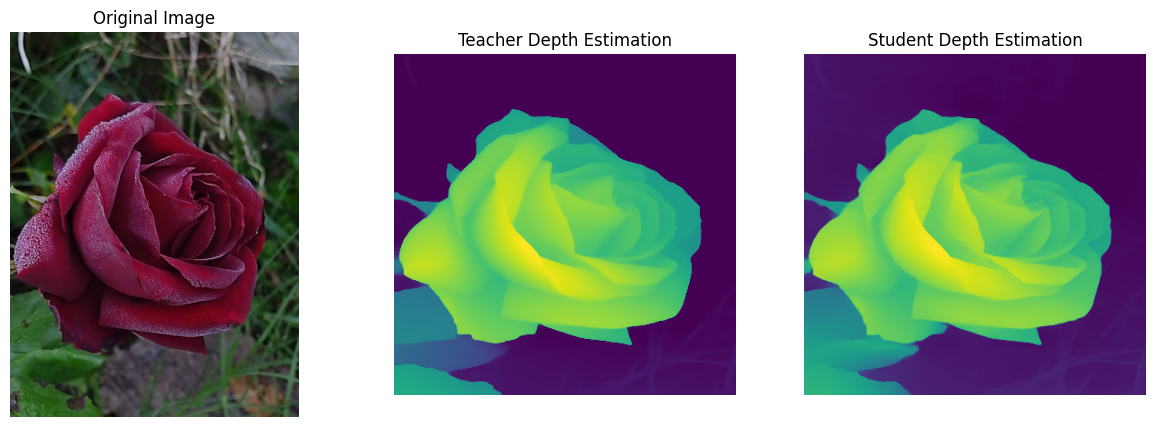

In [101]:
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_depth, cmap="viridis")
plt.title("Student Depth Estimation")
plt.axis("off")

plt.show()

# todo
use torch distill


In [ ]:
# from torchdistill.core.distillation import DistillationBox
# from torchdistill.datasets.util import build_data_loaders

# import yaml

# # Load YAML config file into a dictionary
# with open("config.yaml", "r") as f:
#     config_dict = yaml.safe_load(f)

# # Initialize distillation

# distiller = DistillationBox(
#     teacher_model=teacher,
#     student_model=student,
#     dataset_dict={"train": dataloader, "val": None},
#     device_ids=[0],
#     distributed=False,
#     lr_factor=1.0,
#     train_config=config_dict,
#     device="cuda"
# )

# # Training loop
# for epoch in range(30):
#     for batch in dataloader:
#         inputs = batch.to("cuda")

#         # Forward pass through teacher (no labels needed)
#         with torch.no_grad():
#             teacher_outputs = teacher(inputs)

#         # Forward pass through student
#         student_outputs = student(inputs)

#         # Compute distillation loss
#         loss = distiller.criterion(
#             student_outputs=student_outputs,
#             teacher_outputs=teacher_outputs,
#             inputs=inputs
#         )

#         # Backpropagation
#         distiller.optimizer.zero_grad()
#         loss.backward()
#         distiller.optimizer.step()

#     print(f"Epoch {epoch+1}/30 | Loss: {loss.item():.4f}")